# <center> NMF Model with Word2Vec vectors</center>

In [45]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

# Extracted Features

In [46]:
labels=pickle.load( open('labels.pkl', 'rb'))
features=pickle.load( open('features.pkl', 'rb'))
features_tfidf= pickle.load( open('features_tfidf.pkl', 'rb'))
word_tfidf_weights=pickle.load( open('word_tfidf_weights.pkl', 'rb'))
non_text_features_np = features.drop(columns=['title', 'text', 'combined_text', 'label']).to_numpy()
w2v=pickle.load( open('word_tfidf_weights.pkl', 'rb'))

In [47]:
def plot_loss_acc(history):
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# NMF features with non text features

In [48]:
nmf_sk_model = NMF(n_components=10, init='random', random_state=0)
nmf_vecs = nmf_sk_model.fit_transform(w2v) # nmf vectors
nmf_coeff = nmf_sk_model.components_ # nmf coeffcient

C:\Users\jashi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [31]:
# combining nmf vecs and non text features
features_nmf = np.hstack((nmf_vecs, non_text_features_np))

In [32]:
train_ft,test_ft,train_labels,test_labels=train_test_split(features_nmf,labels,test_size=0.2, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(train_ft, train_labels, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", test_ft.shape)

Training set shape: (45783, 25)
Validation set shape: (11446, 25)
Test set shape: (14308, 25)


# Training NMF vectors

In [33]:
class NMF_model(Model):
    def __init__(self):
        super(NMF_model,self).__init__()
        self.Dense_1= Dense(64, activation="relu")
        self.Dense_2= Dense(32,activation="relu")
        self.model_output= Dense(1,activation="sigmoid")
        
    def call(self,inputs):
        x=self.Dense_1(inputs)
        x=self.Dense_2(x)
        x=self.model_output(x)
        
        return x

In [43]:
# building the model
nmf_model=NMF_model()
nmf_model.build((None,25))
print(nmf_model.summary())

Model: "nmf_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             multiple                  1664      
                                                                 
 dense_10 (Dense)            multiple                  2080      
                                                                 
 dense_11 (Dense)            multiple                  33        
                                                                 
Total params: 3,777
Trainable params: 3,777
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
# Comfiguring the model
opt=keras.optimizers.Adam(learning_rate=0.001)
nmf_model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# early stopping if the validation loss doesnt improve after 3 epochs
early_stop= tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# saving the model
save_model=tf.keras.callbacks.ModelCheckpoint("NMF_model", save_best_only=True)

# Training the model

In [36]:
history=nmf_model.fit(
    train_ft, 
    train_labels, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_val, y_val),
    callbacks=[save_model,early_stop])

Epoch 1/20
1789/1789 [==============================] - 6s 3ms/step - loss: 3.8768 - accuracy: 0.6974 - val_loss: 1.1657 - val_accuracy: 0.7299
Epoch 2/20
1789/1789 [==============================] - 5s 3ms/step - loss: 1.3268 - accuracy: 0.7597 - val_loss: 0.4011 - val_accuracy: 0.8514
Epoch 3/20
1789/1789 [==============================] - 5s 3ms/step - loss: 1.1931 - accuracy: 0.7800 - val_loss: 1.2629 - val_accuracy: 0.6857
Epoch 4/20
1789/1789 [==============================] - 5s 3ms/step - loss: 0.9143 - accuracy: 0.7992 - val_loss: 0.5512 - val_accuracy: 0.8467
Epoch 5/20
1789/1789 [==============================] - 5s 3ms/step - loss: 0.7705 - accuracy: 0.8094 - val_loss: 0.7411 - val_accuracy: 0.7447


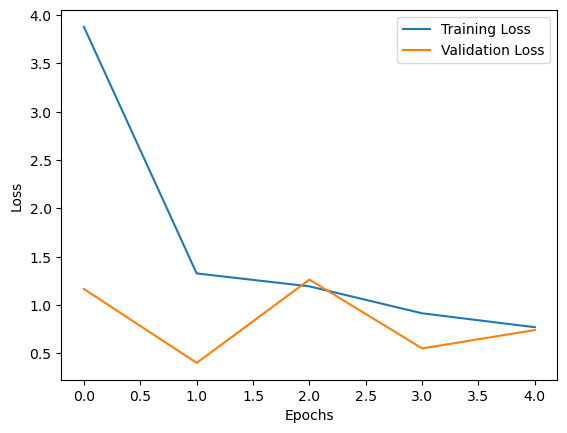

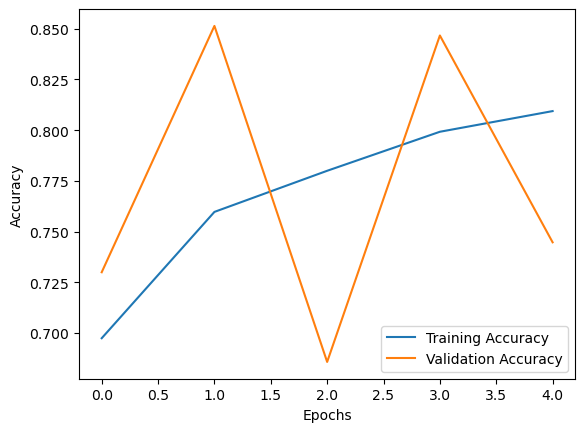

In [41]:
plot_loss_acc(history)

# Loading and Predicting

In [37]:
loaded_model = tf.keras.models.load_model('NMF_model')

In [38]:
metrics=loaded_model.evaluate(test_ft,test_labels)
print(f" Accuracy : {metrics[1]*100} \n Loss : {metrics[0]}")

448/448 [==============================] - 1s 2ms/step - loss: 0.3761 - accuracy: 0.8580
 Accuracy : 85.79815626144409 
 Loss : 0.3761415183544159
